In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, torch, pickle, csv
import numpy as np
import scipy as sp
sys.path.append('/lfs/1/danfu/metal')
sys.path.append('/lfs/1/danfu/sequential_ws')
from metal.metrics import metric_score
from torch.nn.functional import normalize
from DP.label_model import *
import pandas as pd
import matplotlib.pyplot as plt

from metal.analysis import lf_summary
from metal.label_model.baselines import MajorityLabelVoter
from metal.label_model import LabelModel

# Train Metal LabelModel

In [3]:
L_train_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_train_100_windows_high_pre_downsampled.npz'
L_dev_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_val_windows_high_pre_downsampled.npz'
Y_dev_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/Y_val_windows_high_pre_downsampled.npy'
L_test_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_test_windows_high_pre_downsampled.npz'
Y_test_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/Y_test_windows_high_pre_downsampled.npy'

stride = 1
L_train = sp.sparse.load_npz(L_train_path).todense()[::stride]
L_dev = sp.sparse.load_npz(L_dev_path).todense()
Y_dev = np.load(Y_dev_path)
L_test = sp.sparse.load_npz(L_test_path).todense()
Y_test = np.load(Y_test_path)

In [4]:
label_model = LabelModel(k=2, seed=123)
label_model.train_model(L_train, class_balance=(0.15, 0.85), n_epochs=500, log_train_every=50)
label_model.score((L_dev, Y_dev), metric=['accuracy','precision', 'recall', 'f1'])

Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.065]
[100 epo]: TRAIN:[loss=0.051]
[150 epo]: TRAIN:[loss=0.046]
[200 epo]: TRAIN:[loss=0.044]
[250 epo]: TRAIN:[loss=0.044]
[300 epo]: TRAIN:[loss=0.044]
[350 epo]: TRAIN:[loss=0.044]
[400 epo]: TRAIN:[loss=0.044]
[450 epo]: TRAIN:[loss=0.044]
[500 epo]: TRAIN:[loss=0.044]
Finished Training
Accuracy: 0.952
Precision: 0.851
Recall: 0.810
F1: 0.830
        y=1    y=2   
 l=1    222    39    
 l=2    52    1573   


[0.9517497348886532,
 0.8505747126436781,
 0.8102189781021898,
 0.8299065420560746]

# Tune Metal LabelModel

In [5]:
from metal.tuners.random_tuner import RandomSearchTuner
#label_model_everything_windows_tuned = LabelModel(k=2, seed=123)
random_tuner = RandomSearchTuner(LabelModel, seed=123, validation_metric='f1')

In [6]:
search_space = {
    'seed' : [123],
    'n_epochs': list(range(500, 2000, 100)),
    'lr': {'range': [1e-5, .1], 'scale': 'log'},
    'l2': {'range': [1e-5, .1], 'scale': 'log'},
    'log_train_every': [100],
    'class_balance': [
        (i * .1, 1 - i * .1)
        for i in range(1, 10)
    ]
#     'Y_dev': [Y_test_windows]
}

In [7]:
best_random_model = random_tuner.search(search_space,
                                (L_dev, Y_dev),
                               train_args= [L_train],
                               train_kwargs = {
#                                    'Y_dev': Y_test_windows
#                                    'class_balance': (0.2, 0.8)
                               },
                               init_kwargs={
                                   'k': 2
                               }, verbose=True)

[0] Testing {'seed': 123, 'n_epochs': 1500, 'log_train_every': 100, 'class_balance': (0.6000000000000001, 0.3999999999999999), 'lr': 1.3078185548764493e-05, 'l2': 0.0001949089827110901}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=2.465]
[200 epo]: TRAIN:[loss=2.323]
[300 epo]: TRAIN:[loss=2.182]
[400 epo]: TRAIN:[loss=2.044]
[500 epo]: TRAIN:[loss=1.909]
[600 epo]: TRAIN:[loss=1.778]
[700 epo]: TRAIN:[loss=1.652]
[800 epo]: TRAIN:[loss=1.530]
[900 epo]: TRAIN:[loss=1.414]
[1000 epo]: TRAIN:[loss=1.303]
[1100 epo]: TRAIN:[loss=1.198]
[1200 epo]: TRAIN:[loss=1.099]
[1300 epo]: TRAIN:[loss=1.007]
[1400 epo]: TRAIN:[loss=0.920]
[1500 epo]: TRAIN:[loss=0.840]
Finished Training
[1] Testing {'seed': 123, 'n_epochs': 500, 'log_train_every': 100, 'class_balance': (0.8, 0.19999999999999996), 'lr': 0.06653717702911237, 'l2': 1.355578353389003e-05}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.044]
[200 epo]: TRAIN:[loss=0.044]
[300 epo]: TRAIN:[loss=0.044]
[400 epo]: TRAIN

[12] Testing {'seed': 123, 'n_epochs': 1100, 'log_train_every': 100, 'class_balance': (0.6000000000000001, 0.3999999999999999), 'lr': 0.000297819235319664, 'l2': 0.0013793745308172524}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.452]
[200 epo]: TRAIN:[loss=0.126]
[300 epo]: TRAIN:[loss=0.107]
[400 epo]: TRAIN:[loss=0.098]
[500 epo]: TRAIN:[loss=0.091]
[600 epo]: TRAIN:[loss=0.085]
[700 epo]: TRAIN:[loss=0.080]
[800 epo]: TRAIN:[loss=0.075]
[900 epo]: TRAIN:[loss=0.071]
[1000 epo]: TRAIN:[loss=0.067]
[1100 epo]: TRAIN:[loss=0.064]
Finished Training
[13] Testing {'seed': 123, 'n_epochs': 1000, 'log_train_every': 100, 'class_balance': (0.1, 0.9), 'lr': 0.00022433511979938275, 'l2': 3.007910549117966e-05}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.134]
[200 epo]: TRAIN:[loss=0.072]
[300 epo]: TRAIN:[loss=0.071]
[400 epo]: TRAIN:[loss=0.070]
[500 epo]: TRAIN:[loss=0.070]
[600 epo]: TRAIN:[loss=0.069]
[700 epo]: TRAIN:[loss=0.068]
[800 epo]: TRAIN:[loss=0.068]
[9

[1100 epo]: TRAIN:[loss=0.044]
[1200 epo]: TRAIN:[loss=0.044]
[1300 epo]: TRAIN:[loss=0.044]
[1400 epo]: TRAIN:[loss=0.044]
Finished Training
[23] Testing {'seed': 123, 'n_epochs': 1600, 'log_train_every': 100, 'class_balance': (0.4, 0.6), 'lr': 2.6248839405173808e-05, 'l2': 0.008040899823127697}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=2.059]
[200 epo]: TRAIN:[loss=1.685]
[300 epo]: TRAIN:[loss=1.348]
[400 epo]: TRAIN:[loss=1.056]
[500 epo]: TRAIN:[loss=0.813]
[600 epo]: TRAIN:[loss=0.619]
[700 epo]: TRAIN:[loss=0.470]
[800 epo]: TRAIN:[loss=0.359]
[900 epo]: TRAIN:[loss=0.280]
[1000 epo]: TRAIN:[loss=0.224]
[1100 epo]: TRAIN:[loss=0.185]
[1200 epo]: TRAIN:[loss=0.159]
[1300 epo]: TRAIN:[loss=0.141]
[1400 epo]: TRAIN:[loss=0.130]
[1500 epo]: TRAIN:[loss=0.122]
[1600 epo]: TRAIN:[loss=0.117]
Finished Training
[24] Testing {'seed': 123, 'n_epochs': 1400, 'log_train_every': 100, 'class_balance': (0.6000000000000001, 0.3999999999999999), 'lr': 7.93628220714195e-05, 'l2': 0.

Estimating \mu...
[100 epo]: TRAIN:[loss=0.086]
[200 epo]: TRAIN:[loss=0.066]
[300 epo]: TRAIN:[loss=0.055]
[400 epo]: TRAIN:[loss=0.049]
[500 epo]: TRAIN:[loss=0.047]
[600 epo]: TRAIN:[loss=0.046]
[700 epo]: TRAIN:[loss=0.045]
[800 epo]: TRAIN:[loss=0.044]
Finished Training
[34] Testing {'seed': 123, 'n_epochs': 900, 'log_train_every': 100, 'class_balance': (0.6000000000000001, 0.3999999999999999), 'lr': 0.036478696399219704, 'l2': 0.05518550995079234}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.048]
[200 epo]: TRAIN:[loss=0.048]
[300 epo]: TRAIN:[loss=0.048]
[400 epo]: TRAIN:[loss=0.048]
[500 epo]: TRAIN:[loss=0.048]
[600 epo]: TRAIN:[loss=0.048]
[700 epo]: TRAIN:[loss=0.048]
[800 epo]: TRAIN:[loss=0.048]
[900 epo]: TRAIN:[loss=0.048]
Finished Training
[35] Testing {'seed': 123, 'n_epochs': 1700, 'log_train_every': 100, 'class_balance': (0.7000000000000001, 0.29999999999999993), 'lr': 3.481640713879478e-05, 'l2': 0.04051086875161767}
Computing O...
Estimating \mu...
[10

[45] Testing {'seed': 123, 'n_epochs': 1300, 'log_train_every': 100, 'class_balance': (0.7000000000000001, 0.29999999999999993), 'lr': 0.00027706574909898093, 'l2': 0.0006967002409285529}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.937]
[200 epo]: TRAIN:[loss=0.157]
[300 epo]: TRAIN:[loss=0.103]
[400 epo]: TRAIN:[loss=0.095]
[500 epo]: TRAIN:[loss=0.090]
[600 epo]: TRAIN:[loss=0.086]
[700 epo]: TRAIN:[loss=0.082]
[800 epo]: TRAIN:[loss=0.079]
[900 epo]: TRAIN:[loss=0.076]
[1000 epo]: TRAIN:[loss=0.073]
[1100 epo]: TRAIN:[loss=0.070]
[1200 epo]: TRAIN:[loss=0.067]
[1300 epo]: TRAIN:[loss=0.065]
Finished Training
[46] Testing {'seed': 123, 'n_epochs': 1600, 'log_train_every': 100, 'class_balance': (0.2, 0.8), 'lr': 0.06772254330677809, 'l2': 0.026497437002342153}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.045]
[200 epo]: TRAIN:[loss=0.045]
[300 epo]: TRAIN:[loss=0.045]
[400 epo]: TRAIN:[loss=0.045]
[500 epo]: TRAIN:[loss=0.045]
[600 epo]: TRAIN:[loss=0.045]
[

[57] Testing {'seed': 123, 'n_epochs': 1100, 'log_train_every': 100, 'class_balance': (0.30000000000000004, 0.7), 'lr': 0.00033292040819101344, 'l2': 0.002207373260759409}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.106]
[200 epo]: TRAIN:[loss=0.092]
[300 epo]: TRAIN:[loss=0.088]
[400 epo]: TRAIN:[loss=0.084]
[500 epo]: TRAIN:[loss=0.081]
[600 epo]: TRAIN:[loss=0.077]
[700 epo]: TRAIN:[loss=0.074]
[800 epo]: TRAIN:[loss=0.071]
[900 epo]: TRAIN:[loss=0.069]
[1000 epo]: TRAIN:[loss=0.066]
[1100 epo]: TRAIN:[loss=0.064]
Finished Training
[58] Testing {'seed': 123, 'n_epochs': 700, 'log_train_every': 100, 'class_balance': (0.8, 0.19999999999999996), 'lr': 0.00015633508515112553, 'l2': 0.0007281023608557489}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=2.506]
[200 epo]: TRAIN:[loss=0.987]
[300 epo]: TRAIN:[loss=0.253]
[400 epo]: TRAIN:[loss=0.122]
[500 epo]: TRAIN:[loss=0.106]
[600 epo]: TRAIN:[loss=0.103]
[700 epo]: TRAIN:[loss=0.102]
Finished Training
[59] Testing

Estimating \mu...
[100 epo]: TRAIN:[loss=0.351]
[200 epo]: TRAIN:[loss=0.098]
[300 epo]: TRAIN:[loss=0.093]
[400 epo]: TRAIN:[loss=0.090]
[500 epo]: TRAIN:[loss=0.088]
[600 epo]: TRAIN:[loss=0.085]
[700 epo]: TRAIN:[loss=0.083]
[800 epo]: TRAIN:[loss=0.081]
[900 epo]: TRAIN:[loss=0.079]
[1000 epo]: TRAIN:[loss=0.077]
Finished Training
[70] Testing {'seed': 123, 'n_epochs': 1000, 'log_train_every': 100, 'class_balance': (0.9, 0.09999999999999998), 'lr': 0.05847705764991769, 'l2': 0.0024590191325910816}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.045]
[200 epo]: TRAIN:[loss=0.044]
[300 epo]: TRAIN:[loss=0.044]
[400 epo]: TRAIN:[loss=0.044]
[500 epo]: TRAIN:[loss=0.044]
[600 epo]: TRAIN:[loss=0.044]
[700 epo]: TRAIN:[loss=0.044]
[800 epo]: TRAIN:[loss=0.044]
[900 epo]: TRAIN:[loss=0.044]
[1000 epo]: TRAIN:[loss=0.044]
Finished Training
[71] Testing {'seed': 123, 'n_epochs': 1500, 'log_train_every': 100, 'class_balance': (0.9, 0.09999999999999998), 'lr': 1.3446681707010674e-0

[800 epo]: TRAIN:[loss=0.127]
[900 epo]: TRAIN:[loss=0.121]
[1000 epo]: TRAIN:[loss=0.117]
[1100 epo]: TRAIN:[loss=0.114]
[1200 epo]: TRAIN:[loss=0.111]
Finished Training
[81] Testing {'seed': 123, 'n_epochs': 1400, 'log_train_every': 100, 'class_balance': (0.1, 0.9), 'lr': 4.610137991850946e-05, 'l2': 0.008840800631085851}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=2.035]
[200 epo]: TRAIN:[loss=1.133]
[300 epo]: TRAIN:[loss=0.540]
[400 epo]: TRAIN:[loss=0.246]
[500 epo]: TRAIN:[loss=0.130]
[600 epo]: TRAIN:[loss=0.090]
[700 epo]: TRAIN:[loss=0.078]
[800 epo]: TRAIN:[loss=0.074]
[900 epo]: TRAIN:[loss=0.073]
[1000 epo]: TRAIN:[loss=0.072]
[1100 epo]: TRAIN:[loss=0.072]
[1200 epo]: TRAIN:[loss=0.071]
[1300 epo]: TRAIN:[loss=0.071]
[1400 epo]: TRAIN:[loss=0.071]
Finished Training
[82] Testing {'seed': 123, 'n_epochs': 1300, 'log_train_every': 100, 'class_balance': (0.6000000000000001, 0.3999999999999999), 'lr': 0.00133329485941791, 'l2': 5.9734969395848886e-05}
Computing O..

[1000 epo]: TRAIN:[loss=0.090]
[1100 epo]: TRAIN:[loss=0.089]
[1200 epo]: TRAIN:[loss=0.088]
[1300 epo]: TRAIN:[loss=0.087]
Finished Training
[93] Testing {'seed': 123, 'n_epochs': 1700, 'log_train_every': 100, 'class_balance': (0.4, 0.6), 'lr': 0.05229281954338829, 'l2': 0.08086789794075748}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.050]
[200 epo]: TRAIN:[loss=0.050]
[300 epo]: TRAIN:[loss=0.050]
[400 epo]: TRAIN:[loss=0.050]
[500 epo]: TRAIN:[loss=0.050]
[600 epo]: TRAIN:[loss=0.050]
[700 epo]: TRAIN:[loss=0.050]
[800 epo]: TRAIN:[loss=0.050]
[900 epo]: TRAIN:[loss=0.050]
[1000 epo]: TRAIN:[loss=0.050]
[1100 epo]: TRAIN:[loss=0.050]
[1200 epo]: TRAIN:[loss=0.050]
[1300 epo]: TRAIN:[loss=0.050]
[1400 epo]: TRAIN:[loss=0.050]
[1500 epo]: TRAIN:[loss=0.050]
[1600 epo]: TRAIN:[loss=0.050]
[1700 epo]: TRAIN:[loss=0.050]
Finished Training
[94] Testing {'seed': 123, 'n_epochs': 900, 'log_train_every': 100, 'class_balance': (0.2, 0.8), 'lr': 0.07755152173936314, 'l2': 9.50421

[800 epo]: TRAIN:[loss=0.044]
[900 epo]: TRAIN:[loss=0.044]
Finished Training
[105] Testing {'seed': 123, 'n_epochs': 1700, 'log_train_every': 100, 'class_balance': (0.5, 0.5), 'lr': 0.0004541019892816189, 'l2': 0.0011020803298043386}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.129]
[200 epo]: TRAIN:[loss=0.107]
[300 epo]: TRAIN:[loss=0.095]
[400 epo]: TRAIN:[loss=0.086]
[500 epo]: TRAIN:[loss=0.078]
[600 epo]: TRAIN:[loss=0.071]
[700 epo]: TRAIN:[loss=0.066]
[800 epo]: TRAIN:[loss=0.062]
[900 epo]: TRAIN:[loss=0.058]
[1000 epo]: TRAIN:[loss=0.055]
[1100 epo]: TRAIN:[loss=0.053]
[1200 epo]: TRAIN:[loss=0.052]
[1300 epo]: TRAIN:[loss=0.050]
[1400 epo]: TRAIN:[loss=0.049]
[1500 epo]: TRAIN:[loss=0.048]
[1600 epo]: TRAIN:[loss=0.047]
[1700 epo]: TRAIN:[loss=0.047]
Finished Training
[106] Testing {'seed': 123, 'n_epochs': 500, 'log_train_every': 100, 'class_balance': (0.9, 0.09999999999999998), 'lr': 0.04788729643800726, 'l2': 0.000365337237403794}
Computing O...
Estimating \

[1400 epo]: TRAIN:[loss=0.044]
[1500 epo]: TRAIN:[loss=0.044]
[1600 epo]: TRAIN:[loss=0.044]
[1700 epo]: TRAIN:[loss=0.044]
[1800 epo]: TRAIN:[loss=0.044]
Finished Training
[117] Testing {'seed': 123, 'n_epochs': 1800, 'log_train_every': 100, 'class_balance': (0.9, 0.09999999999999998), 'lr': 0.004547163527731377, 'l2': 0.008801280001224977}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.108]
[200 epo]: TRAIN:[loss=0.102]
[300 epo]: TRAIN:[loss=0.095]
[400 epo]: TRAIN:[loss=0.087]
[500 epo]: TRAIN:[loss=0.079]
[600 epo]: TRAIN:[loss=0.073]
[700 epo]: TRAIN:[loss=0.067]
[800 epo]: TRAIN:[loss=0.062]
[900 epo]: TRAIN:[loss=0.058]
[1000 epo]: TRAIN:[loss=0.054]
[1100 epo]: TRAIN:[loss=0.050]
[1200 epo]: TRAIN:[loss=0.048]
[1300 epo]: TRAIN:[loss=0.046]
[1400 epo]: TRAIN:[loss=0.045]
[1500 epo]: TRAIN:[loss=0.045]
[1600 epo]: TRAIN:[loss=0.044]
[1700 epo]: TRAIN:[loss=0.044]
[1800 epo]: TRAIN:[loss=0.044]
Finished Training
[118] Testing {'seed': 123, 'n_epochs': 1800, 'log_train

[100 epo]: TRAIN:[loss=0.072]
[200 epo]: TRAIN:[loss=0.070]
[300 epo]: TRAIN:[loss=0.068]
[400 epo]: TRAIN:[loss=0.067]
[500 epo]: TRAIN:[loss=0.065]
[600 epo]: TRAIN:[loss=0.064]
Finished Training
[129] Testing {'seed': 123, 'n_epochs': 800, 'log_train_every': 100, 'class_balance': (0.1, 0.9), 'lr': 6.689547486010831e-05, 'l2': 9.048292033649532e-05}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=1.637]
[200 epo]: TRAIN:[loss=0.597]
[300 epo]: TRAIN:[loss=0.191]
[400 epo]: TRAIN:[loss=0.094]
[500 epo]: TRAIN:[loss=0.076]
[600 epo]: TRAIN:[loss=0.073]
[700 epo]: TRAIN:[loss=0.072]
[800 epo]: TRAIN:[loss=0.072]
Finished Training
[130] Testing {'seed': 123, 'n_epochs': 1900, 'log_train_every': 100, 'class_balance': (0.8, 0.19999999999999996), 'lr': 0.013775274647056508, 'l2': 0.00023218247063874441}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.055]
[200 epo]: TRAIN:[loss=0.044]
[300 epo]: TRAIN:[loss=0.044]
[400 epo]: TRAIN:[loss=0.044]
[500 epo]: TRAIN:[loss=0.044]

In [30]:
best_random_model.score((L_test, Y_test), metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.920
Precision: 0.888
Recall: 0.704
F1: 0.786
        y=1    y=2   
 l=1    262    33    
 l=2    110   1373   


[0.9195725534308211, 0.888135593220339, 0.7043010752688172, 0.7856071964017992]

# Save/Load Best Model

In [9]:
torch.save(best_random_model, 'models/metal_labelmodel_high_pre_downsampled.pth')

In [10]:
model = torch.load('models/metal_labelmodel_high_pre_downsampled.pth')

# Make Predictions for Everything and Save to Disk

In [11]:
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
import pickle
import rekall
from rekall.video_interval_collection import VideoIntervalCollection
from rekall.interval_list import IntervalList
from rekall.temporal_predicates import *
from metal.label_model.baselines import MajorityLabelVoter

# Load Manually Annotated Data

In [12]:
with open('../../data/manually_annotated_shots.pkl', 'rb') as f:
    shots = VideoIntervalCollection(pickle.load(f))
with open('../../data/shot_detection_folds.pkl', 'rb') as f:
    shot_detection_folds = pickle.load(f)
clips = shots.dilate(1).coalesce().dilate(-1)
shot_boundaries = shots.map(
    lambda intrvl: (intrvl.start, intrvl.start, intrvl.payload)
).set_union(
    shots.map(lambda intrvl: (intrvl.end + 1, intrvl.end + 1, intrvl.payload))
).coalesce()
boundary_frames = {
    video_id: [
        intrvl.start
        for intrvl in shot_boundaries.get_intervallist(video_id).get_intervals()
    ]
    for video_id in shot_boundaries.get_allintervals()
}
video_ids = sorted(list(clips.get_allintervals().keys()))
frames_per_video = {
    video_id: sorted([
        f
        for interval in clips.get_intervallist(video_id).get_intervals()
        for f in range(interval.start, interval.end + 2)
    ])
    for video_id in video_ids
}
ground_truth = {
    video_id: [
        1 if f in boundary_frames[video_id] else 2
        for f in frames_per_video[video_id]
    ] 
    for video_id in video_ids
}

100%|██████████| 28/28 [00:00<00:00, 50994.58it/s]


# Load Label Matrix with All Frames in it

In [13]:
with open('../../data/shot_detection_weak_labels/all_labels_high_pre.pkl', 'rb') as f:
    weak_labels_all_movies = pickle.load(f)

# Load Videos and Number of Frames Per Video

In [14]:
with open('../../data/frame_counts.pkl', 'rb') as f:
    frame_counts = pickle.load(f)
video_ids_all = sorted(list(frame_counts.keys()))
video_ids_train = sorted(list(set(video_ids_all).difference(set(video_ids))))

# Construct windows for each video

In [15]:
# First, construct windows of 16 frames for each video
windows = VideoIntervalCollection({
    video_id: [
        (f, f + 16, video_id)
        for f in range(0, frame_counts[video_id] - 16, 16)
    ]
    for video_id in video_ids_all
})

# Get weak labels for all windows

In [16]:
# Label windows with the weak labels in our labeling functions
def label_window(per_frame_weak_labels):
    if 1 in per_frame_weak_labels:
        return 1
    if len([l for l in per_frame_weak_labels if l == 2]) >= len(per_frame_weak_labels) / 2:
        return 2
    return 0

windows_with_weak_labels = windows.map(
    lambda window: (
        window.start,
        window.end,
        [
            label_window([
                lf[window.payload][f-1]
                for f in range(window.start, window.end)
            ])
            for lf in weak_labels_all_movies
        ]
    )
)

# L matrix

In [17]:
L_everything_windows = csr_matrix([
    intrvl.payload
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]).todense()

In [18]:
with open('../../data/shot_detection_weak_labels/L_everything_windows_high_pre_downsampled.npy', 'wb') as f:
    np.save(f, L_everything_windows)

In [ ]:
with open('../../data/shot_detection_weak_labels/L_everything_windows_high_pre_downsampled.npy', 'rb') as f:
    L_everything_windows = np.load(f)

# Predict Everything

In [19]:
L_everything_windows.shape

(6175405, 5)

In [20]:
window_predictions_everything = model.predict_proba(L_everything_windows)

In [21]:
window_predictions_everything.shape

(6175405, 2)

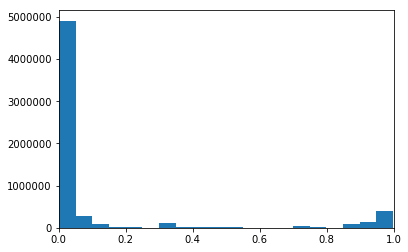

In [22]:
fig, ax = plt.subplots()
ax.hist([
    pred[0] for pred in window_predictions_everything
], bins=20)
ax.set_xlim(0, 1)
plt.show()

In [23]:
window_nums = [
    (video_id, intrvl.start, intrvl.end)
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]

In [24]:
predictions_to_save_windows = [
    (window_info, prediction)
    for window_info, prediction in zip(window_nums, window_predictions_everything)
]

In [25]:
preds_np_windows = np.array(predictions_to_save_windows)

In [26]:
preds_np_windows.shape

(6175405, 2)

In [27]:
# save predictions to disk
with open('../../data/shot_detection_weak_labels/noisy_labels_all_windows_high_pre_downsampled.npy', 'wb') as f:
    np.save(f, preds_np_windows)